AT-RISK DIABETES PREDICTION

In [1]:
#IMPORT LIBRARIES
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_validate

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report


In [2]:
#import files
df = pd.read_csv(r"C:\Users\user\Downloads\Diabetes Health Indicators\diabetes_012_health_indicators_BRFSS2015.csv")


In [3]:
df.sample(10)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
241574,0.0,0.0,0.0,1.0,29.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,4.0,8.0
98198,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,5.0,8.0
129428,0.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,9.0,4.0,8.0
184242,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,7.0,4.0,8.0
117088,0.0,0.0,0.0,1.0,37.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,3.0,6.0,7.0
14549,0.0,1.0,0.0,1.0,46.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,4.0,20.0,20.0,1.0,0.0,5.0,6.0,1.0
81009,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,3.0,4.0
64223,0.0,1.0,0.0,1.0,31.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,7.0,0.0,0.0,0.0,4.0,5.0,8.0
104432,0.0,1.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,20.0,21.0,0.0,1.0,11.0,6.0,8.0
58164,2.0,0.0,0.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,7.0,6.0,8.0


In [4]:
df.rename(columns={'Diabetes_012': 'Diabetes'}, inplace=True)

In [5]:
#drop columns that are not needed for the model
drop_columns = ['CholCheck','AnyHealthcare','NoDocbcCost','Education','Income']
df = df.drop(drop_columns, axis=1)

In [6]:
df.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0
2,0.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0
3,0.0,1.0,0.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0
4,0.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0


In [7]:
df = df.astype(int) #convert all floaat types to int

IDA

In [8]:
# define a function to simplify the plots in further sections
def ida_plot(li_col, row, col=3, figsize=(20, 5)):
    
    
    
    # prepare subplot format
    fig, ax = plt.subplots(row, col, figsize=figsize)
    axe = ax.ravel()

    # use for loop to plot
    for i in range(len(li_col)):

        # create bar charts for each column
        sns.countplot(x=df[li_col[i]], ax=axe[i])

    # adjust the spacing of the subplots
    plt.subplots_adjust(
        wspace=0.5, 
        hspace=0.5
    )

    #This function returns plt subplots by looping trough the columns and displays only the desired ones


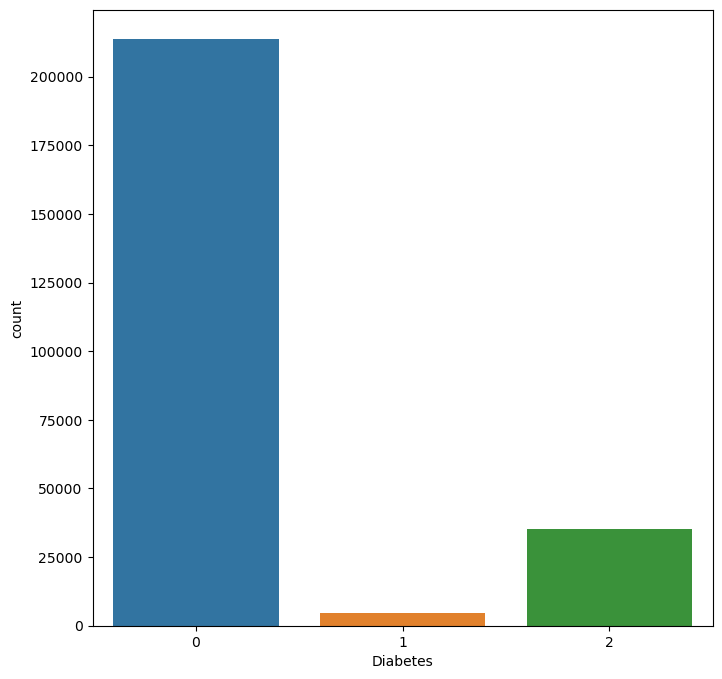

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.countplot(data=df, x='Diabetes', ax=ax)
plt.show()

In [10]:
li_col = [x for x in df.columns if x != ['Diabetes', 'MentHlth', 'BMI','PhysHlth']]

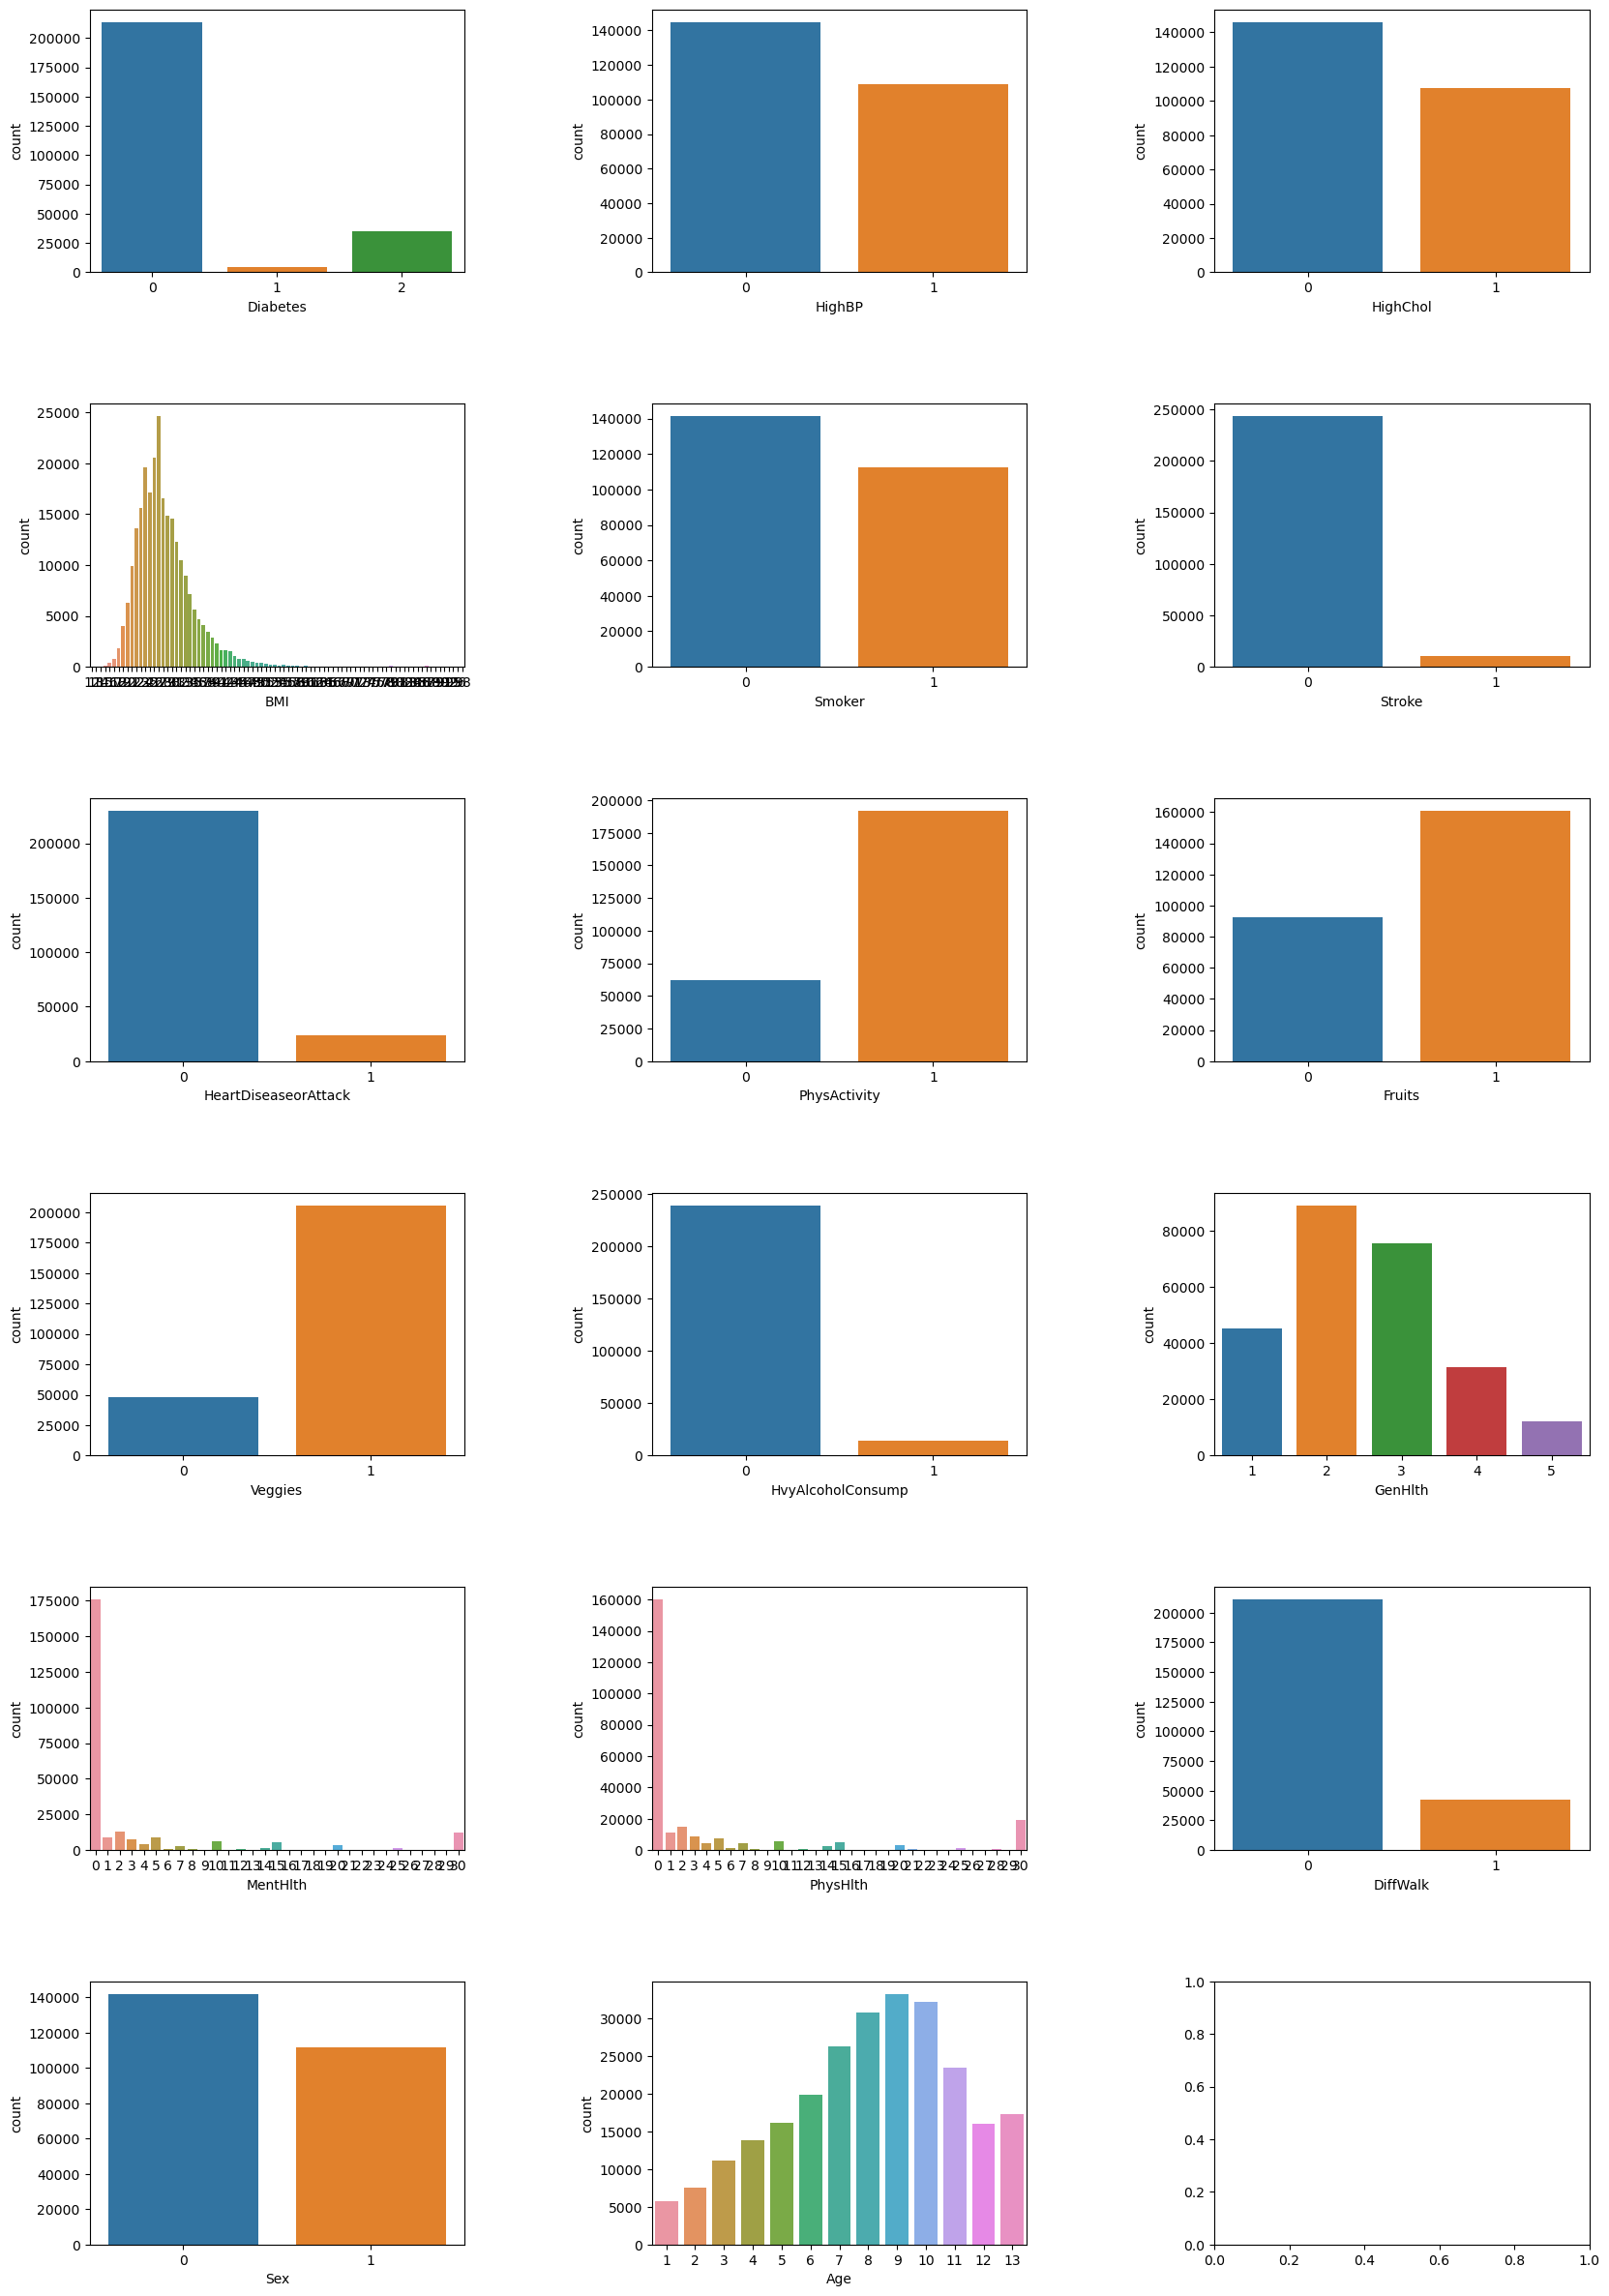

In [11]:
ida_plot(li_col, int(len(li_col)/3+.5), figsize=(20, 30))

Observation: BMI is right skewed

<Axes: xlabel='BMI', ylabel='Count'>

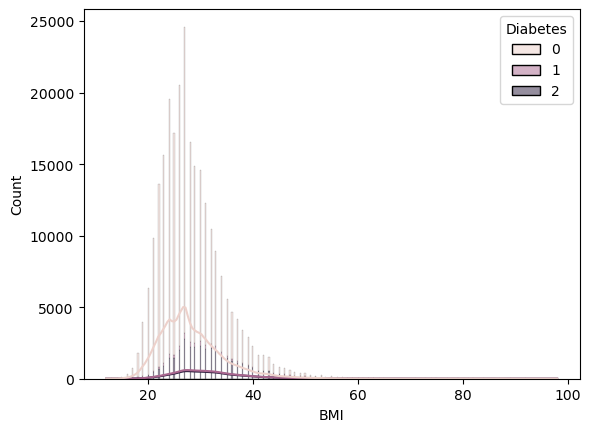

In [12]:
sns.histplot(data=df, x='BMI', hue='Diabetes', multiple='stack', kde=True)

In [13]:
df['BMI'].describe()

#the rest of the subplots can be viewed this way

count    253680.000000
mean         28.382364
std           6.608694
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: BMI, dtype: float64

EDA

    -: Binary classes and balnced classes
    -: Downsampling
    -:Define target and features

In [14]:
#retrieve all indexes of class 2 instances
#convert all class 2 to class 1 values
#check class distribution

diabetes_index = df[df['Diabetes'] == 2].index
df.loc[diabetes_index,['Diabetes']] = 1
df['Diabetes'].value_counts()

Diabetes
0    213703
1     39977
Name: count, dtype: int64

In [15]:
#Downsampling

#1.random select samples from class 0
#2. random select samples from class 1
#3. combine both classes

df_class_0 = df[df['Diabetes'] == 0].sample(39977)
df_class_1 = df[df['Diabetes'] == 1]
df = pd.concat([df_class_0, df_class_1])

#check the shape of the dataframe
df.shape
#check class distribution
df['Diabetes'].value_counts()


Diabetes
0    39977
1    39977
Name: count, dtype: int64

In [16]:
df.shape

(79954, 17)

In [17]:
#split data into features and target
X = df.drop('Diabetes', axis=1) #features
y = df['Diabetes'] #target

In [18]:
#check result
X.sample(5, random_state=42)

,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
132961,1,1,32,1,0,0,1,1,1,0,4,15,0,0,1,10
77382,0,0,28,0,0,0,0,1,1,0,5,0,22,1,1,3
97933,1,0,33,1,0,0,1,0,1,0,2,4,0,0,0,10
24605,1,0,38,0,0,0,0,0,1,0,4,3,30,0,1,10
165431,1,0,43,1,0,0,0,1,1,0,5,0,30,1,0,10


In [19]:
y.sample(5, random_state=42)

132961    0
77382     1
97933     1
24605     1
165431    1
Name: Diabetes, dtype: int32

TRAIN-TEST SPLIT 
1. Original df split into train and test sets
2. Training set split into validation set 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#further split training data into train and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#check shapes of the split

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')

X_train: (51170, 16), X_test: (15991, 16)
y_train: (51170,), y_test: (15991,)


DUMMY CLASSIFIER    

In [21]:
from sklearn.dummy import DummyClassifier

#DEFINE DUMMY CLASSIFIER
dummy_clf = DummyClassifier(strategy='most_frequent')

#FIT
dummy_clf.fit(X_train, y_train) 

#track accuracy scores
train_acc = dummy_clf.score(X_train, y_train)
val_acc = dummy_clf.score(X_val, y_val)

print(f'Training Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')

Training Accuracy: 0.5018174711745164
Validation Accuracy: 0.4951926834987884


Observations:
1. Accuracy score is 50% on the training set and 49.5% on the validation set
2. Precision score = for class 1 is 50%, recall score is 100%

In [22]:
#performance on training set 

print(f'Classification Report:\n{classification_report(y_train, dummy_clf.predict(X_train), zero_division=1)}')

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     25492
           1       0.50      1.00      0.67     25678

    accuracy                           0.50     51170
   macro avg       0.75      0.50      0.33     51170
weighted avg       0.75      0.50      0.34     51170



In [23]:
#performance on validation set
print(f'Classification Report:\n{classification_report(y_val, dummy_clf.predict(X_val), zero_division=1)}')

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      6458
           1       0.50      1.00      0.66      6335

    accuracy                           0.50     12793
   macro avg       0.75      0.50      0.33     12793
weighted avg       0.75      0.50      0.33     12793



DECISION TREE CLASSIFICATION WITH DEFAULT PARAMS

In [24]:
#DEFINE and FIT THE DECISION TREE CLASSIFIER
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train) #fitting the model

#track accuracy scores
train_acc = dt_clf.score(X_train, y_train)
val_acc = dt_clf.score(X_val, y_val)

print(f'Training Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')

Training Accuracy: 0.9720930232558139
Validation Accuracy: 0.654811224888611


In [25]:
#PERFOMANCE ON TRAINING SET
print(f'Classification Report:\n{classification_report(y_train, dt_clf.predict(X_train), zero_division=1)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     25492
           1       0.99      0.95      0.97     25678

    accuracy                           0.97     51170
   macro avg       0.97      0.97      0.97     51170
weighted avg       0.97      0.97      0.97     51170



In [26]:
#PERFOMANCE ON VAL SET
print(f'Classification Report:\n{classification_report(y_val, dt_clf.predict(X_val), zero_division=1)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      6458
           1       0.66      0.64      0.65      6335

    accuracy                           0.65     12793
   macro avg       0.65      0.65      0.65     12793
weighted avg       0.65      0.65      0.65     12793



Observations:
1. f1 score on training set = 97%, validation set = 65%
2. recall score on training set = 95%, validation set = 64%
3. overfitting of data is reflected 

SCALING -: MIN-MAX SCALER

In [27]:
x_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)


ALGOS AND THEIR PARAMS


In [36]:
#DEFINE FUNCTION TO PLOT RESULTS IN FURTHER SECTIONS
def plot_score(title, x_label):
    #gather results of diff metrics on the classifier performance
    #define the name of each metric on the figures
    train_score = [train_acc_score, train_f1_score, train_recall_score]
    val_score = [val_acc_score, val_f1_score, val_recall_score]
    metric_name = ['Accuracy', 'F1', 'Recall']

    #plot the results
    fig, axe = plt.subplots(1, 3, figsize=(20, 5))
    axe = ax.ravel()

    #loop through the lists and plot the 3 figs with corresponding data
    for i, scores in enumerate(zip(train_score, val_score)):
        scores = list(zip(scores[0], scores[1]))
        axe[i].set_title('Influence of ' + title + 'on' + metric_name[i])
        axe[i].set_xlabel(x_label)
        axe[i].set_ylabel(metric_name[i])
        axe[i].plot(li_param, scores[0], c = 'blue')
        axe[i].plot(li_param, scores[1], c = 'red')
        axe[i].legend()
    

Parameter Influence and Handling overfitting: decision tree

In [ ]:
#define max_depth of the decision tree
li_param = [*range(1, 30)]
#create empty list for results storage
train_acc_score = []
train_f1_score = []


